<a href="https://colab.research.google.com/github/sebinbyju007/Intelligent_QA_using_Deep_Learning/blob/main/siamese_bilstm_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from string import punctuation
from collections import defaultdict
# from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Keras package
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, LSTM, Lambda
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.pooling import GlobalAveragePooling1D
import keras.backend as K


In [3]:
# Hyperparameter defination

# Use the following instructions to download glove and unzip it, if already installed, just comment them.
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove.840B.300d.zip
EMBEDDING_FILE = '/content/drive/MyDrive/Project/glove.840B.300d.txt'

TRAIN_DATA_FILE = '/content/drive/MyDrive/Project/train.csv.zip'
TEST_DATA_FILE = '/content/drive/MyDrive/Project/new_test.csv'

MAX_SEQUENCE_LENGTH = 60  
MAX_NUM_WORDS = 200000  # There are about 201000 unique words in training dataset, 200000 is enough for tokenization
EMBEDDING_DIM = 300  # word-embedded-vector dimension(300 is for 'glove.840B.300d')
VALIDATION_SPLIT_RATE = 0.1 
N_HIDDEN = np.random.randint(175, 275)
N_DENSE = np.random.randint(100, 150)
DROPOUT_RATE_LSTM = 0.15 + np.random.rand() * 0.25  # drop-out possibility, random set to avoid outfitting
DROUPOUT_RATE_DENSE = 0.15 + np.random.rand() * 0.25
VERSION = 'Temp/lstm_2'
print('LSTM Stucture:')
print('Num_Lstm:', N_HIDDEN)
print('Num_Dense:', N_DENSE)
print('Dropout rate in LSTM layer:', DROPOUT_RATE_LSTM) 
print('Dropout rate in Dense layer::', DROUPOUT_RATE_DENSE)

ACTIVE_FUNC = 'relu'
re_weight = True  # whether to re-weight classes to fit the 17.4% share in test set


LSTM Stucture:
Num_Lstm: 253
Num_Dense: 142
Dropout rate in LSTM layer: 0.1771441524944857
Dropout rate in Dense layer:: 0.16109813275907078


In [4]:
# Create word embedding dictionary from 'glove.840B.300d.txt', {key:value} is {word: glove vector(300,)}
print('Create word embedding dictionary')

embeddings_index = {}  # the output dictionary
f = open(EMBEDDING_FILE, encoding='utf-8')
for line in f:  # tqdm
    values = line.split()
    word = ''.join(values[:-300])   
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors of glove.'.format(len(embeddings_index)))





Create word embedding dictionary
Found 2195892 word vectors of glove.


In [5]:
# Preprocess text in dataset
print('Processing text dataset')

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        text = [w for w in text if not w in stop_words]
    
    text = " ".join(text)

    # Use re to clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    # text = re.sub(r"\0s", "0", text) # It doesn't make sense to me
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    # or nltk package
    # if lemma:
    #    text = text.split()
    #    wn = nltk.WordNetLemmatizer()
    #    lemm_words = [wn.lemmatize(word) for word in text]
    #    text = " ".join(lemm_words)
    
    # Return a list of words
    return(text)



Processing text dataset


In [6]:
# Load training data and process with text_to_wordlist (Preprocessing)
train_texts_1 = []  # the preprocessed text of q1
train_texts_2 = []  # the preprocessed text of q2
train_labels = []  # training labels

df_train = pd.read_csv(TRAIN_DATA_FILE, encoding='utf-8')  # the original training data
df_train = df_train.fillna('empty')
# train_q1 = df_train.question1.values  # the original text of q1
# train_q2 = df_train.question2.values  # the original text fo q2
train_labels = df_train.is_duplicate.values  # the original label('is_duplicate')

for text in df_train.question1.values:
    train_texts_1.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))
    
for text in df_train.question2.values:
    train_texts_2.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))

print('{} texts are found in train.csv'.format(len(train_texts_1)))



404290 texts are found in train.csv


In [7]:
# Load testing data and process with text_to_wordlist (Preprocessing)
test_texts_1 = []  # the preprocessed text of q1_test
test_texts_2 = []  # the preprocessed text of q2_test
test_ids = []  # id..

df_test = pd.read_csv(TEST_DATA_FILE, encoding='utf-8')[:500]  # the original testing data
df_test = df_test.fillna('empty')
# test_q1 = df_test.question1.values  # the original text of q1_test
# test_q2 = df_test.question2.values  # the original text of q2_test
test_ids = df_test.test_id.values  # id..

for text in df_test.question1.values:
    test_texts_1.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))
    
for text in df_test.question1.values:
    test_texts_2.append(text_to_wordlist(text, remove_stopwords=False, stem_words=False))
    
print('{} texts are found in test.csv'.format(len(test_texts_1)))

500 texts are found in test.csv


In [8]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_texts_1 + train_texts_2 + test_texts_1 + test_texts_2)  # generate a token dictionary, 

train_texts_1 = tokenizer.texts_to_sequences(train_texts_1)  # sequence of q1
train_texts_2 = tokenizer.texts_to_sequences(train_texts_2)  # sequence of q2
test_texts_1 = tokenizer.texts_to_sequences(test_texts_1)  # sequence of q1_test
test_texts_2 = tokenizer.texts_to_sequences(test_texts_2)  # sequence of q2_test

word_index = tokenizer.word_index
print('{} unique tokens are found'.format(len(word_index)))

85552 unique tokens are found


In [9]:
train_texts_1 = pad_sequences(train_texts_1, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q1 as train_data
train_texts_2 = pad_sequences(train_texts_2, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q2 as train_data
print('Shape of train data tensor:', train_texts_1.shape)
print('Shape of train labels tensor:', train_labels.shape)

# Pad all test with Max_Sequence_Length
test_texts_1 = pad_sequences(test_texts_1, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q1_test as test_data
test_texts_2 = pad_sequences(test_texts_2, maxlen=MAX_SEQUENCE_LENGTH)  # padded_sequence of q2_test as test_data
print('Shape of test data vtensor:', test_texts_2.shape)
print('Shape of test ids tensor:', test_ids.shape)

Shape of train data tensor: (404290, 60)
Shape of train labels tensor: (404290,)
Shape of test data vtensor: (500, 60)
Shape of test ids tensor: (500,)


In [10]:
# Get leaky features (NLP features)

import pandas as pd

questions = pd.concat([df_train[['question1', 'question2']], df_test[['question1', 'question2']]], axis=0).reset_index(drop='index')
q_dict = defaultdict(set)
for i in range(questions.shape[0]):
        q_dict[questions.question1[i]].add(questions.question2[i])
        q_dict[questions.question2[i]].add(questions.question1[i])

def q1_freq_train(row):
    return len(q_dict.get(row[3]))
    # return(len(q_dict[row['question1']]))

def q2_freq_train(row):
    return len(q_dict.get(row[4]))
    # return(len(q_dict[row['question2']]))

def q1_q2_intersect_train(row):
    return(len(set(q_dict.get(row[3])).intersection(set(q_dict.get(row[4])))))
    # return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

def q1_freq_test(row):
    return len(q_dict.get(row[1]))
    # return(len(q_dict[row['question1']]))

def q2_freq_test(row):
    return len(q_dict.get(row[2]))
    # return(len(q_dict[row['question2']]))

def q1_q2_intersect_test(row):
    return(len(set(q_dict.get(row[1])).intersection(set(q_dict.get(row[2])))))
    # return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

df_train['q1_q2_intersect'] = df_train.apply(q1_q2_intersect_train, axis=1, raw=True)
df_train['q1_freq'] = df_train.apply(q1_freq_train, axis=1, raw=True)
df_train['q2_freq'] = df_train.apply(q2_freq_train, axis=1, raw=True)

df_test['q1_q2_intersect'] = df_test.apply(q1_q2_intersect_test, axis=1, raw=True)
df_test['q1_freq'] = df_test.apply(q1_freq_test, axis=1, raw=True)
df_test['q2_freq'] = df_test.apply(q2_freq_test, axis=1, raw=True)

leaks = df_train[['q1_q2_intersect', 'q1_freq', 'q2_freq']]  # the leaky feature
test_leaks = df_test[['q1_q2_intersect', 'q1_freq', 'q2_freq']]  # the leaky feature_test


# Make scaling for leaky feature
ss = StandardScaler()
ss.fit(np.vstack((leaks, test_leaks)))
leaks = ss.transform(leaks)  # the leaky feature
test_leaks = ss.transform(test_leaks)  # the leaky feature_test


In [11]:
# Train & Validation split
perm = np.random.permutation(len(train_texts_1))
idx_train = perm[:int(len(train_texts_1)*(1-VALIDATION_SPLIT_RATE))]
idx_val = perm[int(len(train_texts_1)*(1-VALIDATION_SPLIT_RATE)):]

data_1_train = np.vstack((train_texts_1[idx_train], train_texts_2[idx_train]))
data_2_train = np.vstack((train_texts_2[idx_train], train_texts_1[idx_train]))
leaks_train = np.vstack((leaks[idx_train], leaks[idx_train]))
labels_train = np.concatenate((train_labels[idx_train], train_labels[idx_train]))

data_1_val = np.vstack((train_texts_1[idx_val], train_texts_2[idx_val]))
data_2_val = np.vstack((train_texts_2[idx_val], train_texts_1[idx_val]))
leaks_val = np.vstack((leaks[idx_val], leaks[idx_val]))
labels_val = np.concatenate((train_labels[idx_val], train_labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.471544715
    weight_val[labels_val==0] = 1.309033281


In [12]:
from keras.layers import Conv1D

In [19]:
# Create embedding matrix for embedding layer, which is used in the keras.embedding weight as the initializer.
from keras.layers import Bidirectional

print('Preparing embedding matrix')

num_words = min(MAX_NUM_WORDS, len(word_index))+1

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))  # the weight of Embedding layer
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: '.format(np.sum(np.sum(embedding_matrix, axis=1) == 0)))


# NN Model design
# Structure: (q1-embedding-lstm + q2-embedding-lstm + leaky-dense)-dense-sigmoid-result

# The embedding layer containing the word vectors
emb_layer = Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)    

# BiLSTM layer
from keras.layers import Bidirectional
lstm_layer = Bidirectional(LSTM(N_HIDDEN, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM))


# Define inputs
seq1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
seq2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Run inputs through embedding
emb1 = emb_layer(seq1)
emb2 = emb_layer(seq2)

cnn_a = Conv1D(filters=32, kernel_size=8,activation='relu')(emb1)
cnn_b = Conv1D(filters=32, kernel_size=8,activation='relu')(emb2)

# Run through LSTM layers
lstm_a = lstm_layer(cnn_a)
# glob1a = GlobalAveragePooling1D()(lstm_a)
lstm_b = lstm_layer(cnn_b)
# glob1b = GlobalAveragePooling1D()(lstm_b)

magic_input = Input(shape=(leaks.shape[1],))
# magic_dense = BatchNormalization()(magic_input)
magic_dense = Dense(int(N_DENSE/2), activation=ACTIVE_FUNC)(magic_input)

merged = concatenate([lstm_a, lstm_b, magic_dense])
merged = BatchNormalization()(merged)
merged = Dropout(DROUPOUT_RATE_DENSE)(merged)

merged = Dense(N_DENSE, activation=ACTIVE_FUNC)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(DROUPOUT_RATE_DENSE)(merged)

preds = Dense(1, activation='sigmoid')(merged)


# Add class weight, magic feature for the unbalancement of training labels.
if re_weight:
    class_weight = {0: 1.309033281, 1: 0.471544715}
else:
    class_weight = None
    

# Train the model

print('Starting the model training')

model = Model(inputs=[seq1, seq2, magic_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

# Summerization of model
model.summary()


Preparing embedding matrix
Null word embeddings: 
Starting the model training
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 300)      25665900    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv

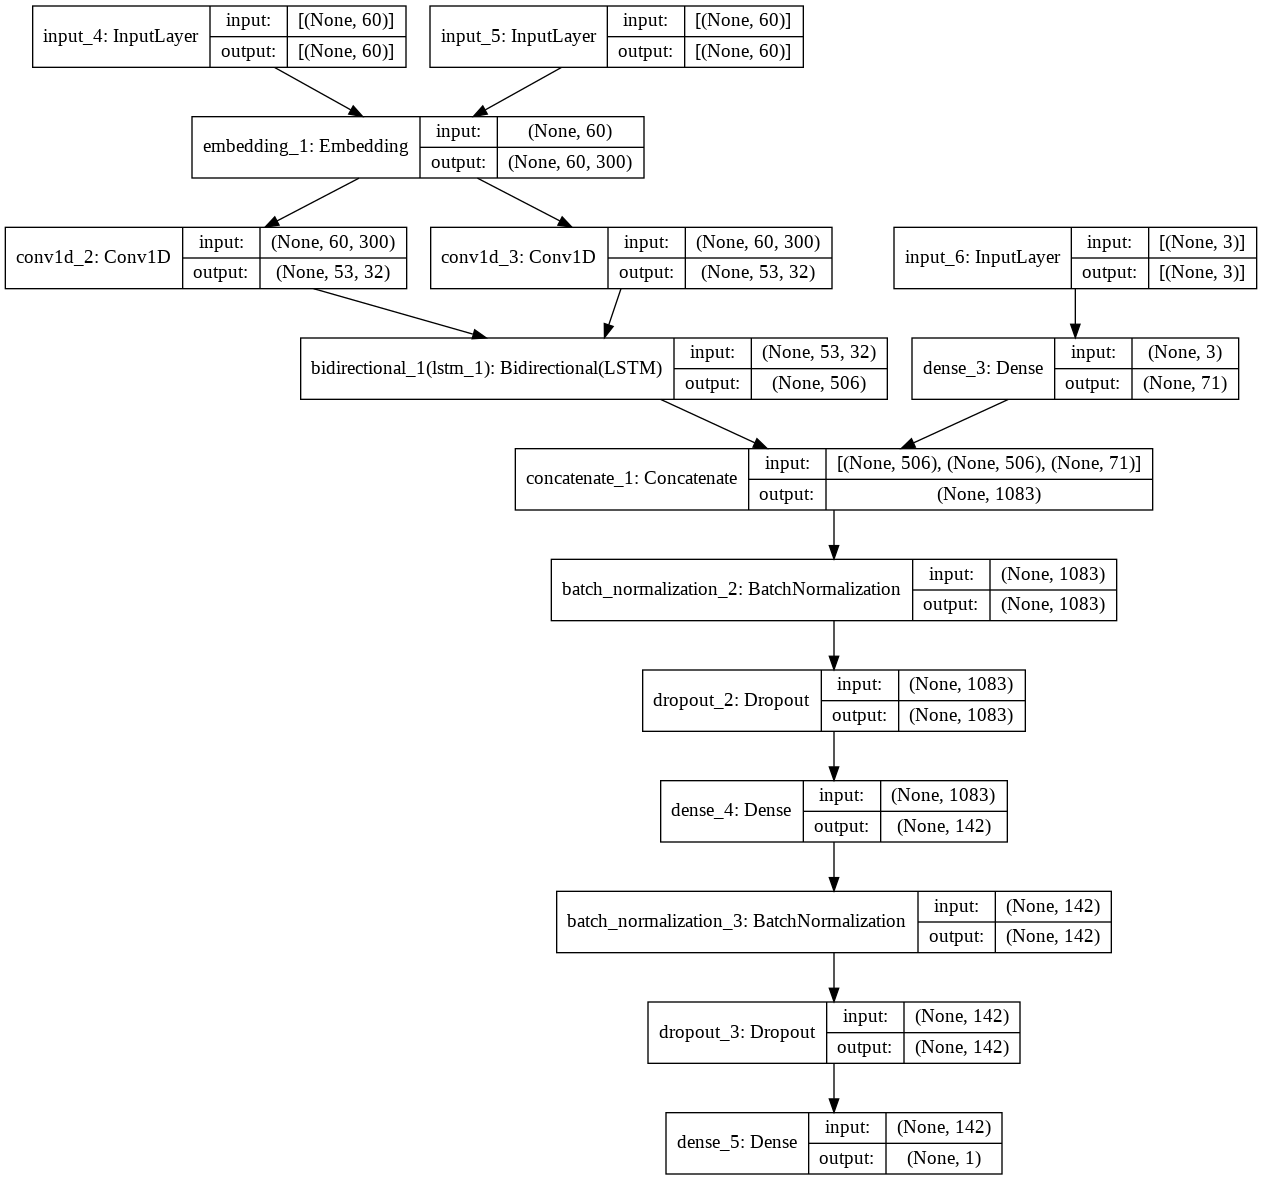

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
# Set early stopping (large patience should be useful)
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = 'lstm_2_cnn' + '.h5' 
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)


hist = model.fit([data_1_train, data_2_train, leaks_train], labels_train, \
        validation_data=([data_1_val, data_2_val, leaks_val], labels_val, weight_val), \
        epochs=4, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

Epoch 1/4
356/356 [==============================] - 377s 1s/step - loss: 0.3118 - acc: 0.8144 - val_loss: 0.2955 - val_acc: 0.7928
Epoch 2/4
356/356 [==============================] - 352s 988ms/step - loss: 0.2303 - acc: 0.8457 - val_loss: 0.2264 - val_acc: 0.8438
Epoch 3/4
356/356 [==============================] - 349s 982ms/step - loss: 0.2164 - acc: 0.8495 - val_loss: 0.2215 - val_acc: 0.8483
Epoch 4/4
356/356 [==============================] - 351s 986ms/step - loss: 0.2066 - acc: 0.8534 - val_loss: 0.2164 - val_acc: 0.8473


In [27]:
model.load_weights(bst_model_path) # sotre model parameters in .h5 file
bst_val_score = min(hist.history['val_loss'])

In [28]:
import matplotlib.pyplot as plt

In [29]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

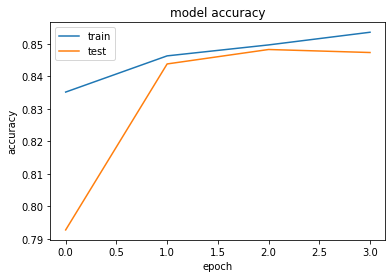

In [30]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

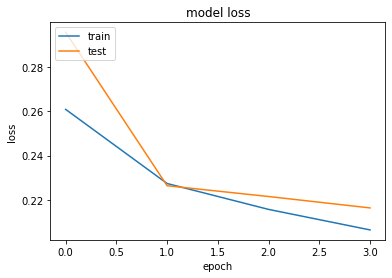

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()